In [7]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle
import glob

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var
from object_pose_utils.utils.display import *

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


### Select Object Indices of Interest

| Object Indices |[]()|[]()|
|---|---|---|
| __1.__ 002_master_chef_can | __8.__ 009_gelatin_box      | __15.__ 035_power_drill       |
| __2.__ 003_cracker_box     | __9.__ 010_potted_meat_can  | __16.__ 036_wood_block        |
| __3.__ 004_sugar_box       | __10.__ 011_banana          | __17.__ 037_scissors          |
| __4.__ 005_tomato_soup_can | __11.__ 019_pitcher_base    | __18.__ 040_large_marker      |
| __5.__ 006_mustard_bottle  | __12.__ 021_bleach_cleanser | __19.__ 051_large_clamp       |
| __6.__ 007_tuna_fish_can   | __13.__ 024_bowl            | __20.__ 052_extra_large_clamp |
| __7.__ 008_pudding_box     | __14.__ 025_mug             | __21.__ 061_foam_brick        |

In [2]:
from transforms3d.quaternions import quat2mat, mat2quat

def getPoseCNNQuat(data, obj):
    pose_idx = np.where(data['rois'][:,1].flatten()==obj)[0]
    if(len(pose_idx) == 0):
        return None
    else:
        pose_idx = pose_idx[0]
    pose = data['poses'][pose_idx]
    q = pose[:4][[1,2,3,0]]
    q /= np.linalg.norm(q)
    t = pose[4:7]
    return q

## YCB Dataset

In [275]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer
from object_pose_utils.datasets.inplane_rotation_augmentation import InplaneRotator

from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.TRANSLATION, 
                 otypes.IMAGE_CROPPED,
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES,
                ]

dataset = YCBDataset(dataset_root, mode=mode,
                     object_list = list(range(1,22)),
                     output_data = output_format,
                     resample_on_error = False,
                     add_syn_background = False,
                     add_syn_noise = False,
                     use_posecnn_data = True,
                     #preprocessors = [InplaneRotator()],
                     postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)

model_clouds = {}
for object_id in object_list:
    cloud_filename = '{}/models/{}/points.xyz'.format(dataset_root, dataset.classes[object_id])
    model_clouds[object_id] = np.loadtxt(cloud_filename)

## Pose Estimator

In [4]:
from dense_fusion.network import PoseNet, PoseNetGlobal, PoseRefineNet, PoseNetDropout

df_weights = '/home/bokorn/src/DenseFusion/trained_checkpoints/ycb/pose_model_26_0.012863246640872631.pth'
df_estimator = PoseNet(num_points = 1000, num_obj = 21)
df_estimator.load_state_dict(torch.load(df_weights))
df_estimator.cuda();
df_estimator.eval();

df_refine_weights = '/home/bokorn/src/DenseFusion/trained_checkpoints/ycb/pose_refine_model_69_0.009449292959118935.pth'
df_refine_estimator = PoseRefineNet(num_points = 1000, num_obj = 21)
df_refine_estimator.load_state_dict(torch.load(df_refine_weights))
df_refine_estimator.cuda();
df_refine_estimator.eval();

df_global_weights = '/home/bokorn/src/DenseFusion/trained_models/ycb_global/pose_model_13_0.02780649198161978.pth'
df_global_estimator = PoseNetGlobal(num_points = 1000, num_obj = 21)
df_global_estimator.load_state_dict(torch.load(df_global_weights))
df_global_estimator.cuda();
df_global_estimator.eval();

df_dropout_weights = '/home/bokorn/src/DenseFusion/trained_models/ycb_dropout/pose_model_36_0.019743827587456554.pth'
df_dropout_estimator = PoseNetDropout(num_points = 1000, num_obj = 21)
df_dropout_estimator.load_state_dict(torch.load(df_dropout_weights))
df_dropout_estimator.cuda();
df_dropout_estimator.eval();

## Distribution Estimators

In [333]:
from se3_distributions.losses.loglik_loss import evaluateFeature
from se3_distributions.models.compare_networks import SigmoidCompareNet, SigmoidNet

#feature_root = '/scratch/bokorn/results/dense_fusion_global_feat/'
feature_root = '/scratch/bokorn/results//'
feature_key = 'feat_global'
feature_size = 1024

grid_vertices = torch.load(os.path.join(feature_root, 'grid',
    '{}_vertices.pt'.format(dataset.classes[1])))

grid_features = {}
for object_id in object_list:
    grid_features[object_id] = torch.load(os.path.join(feature_root, 'grid',
        '{}_{}_features.pt'.format(feature_key, dataset.classes[object_id])))

comp_model_checkpoint_pattern = '/scratch/bokorn/results/log_lik/df_global_orig_comp/lr_1e-5/2019-09-03_22-37-08/weights/checkpoint_*.pth'
comp_model_checkpoint = sorted(glob.glob(comp_model_checkpoint_pattern,
                                        recursive=True))[-1]
comp_estimator = SigmoidCompareNet(feature_size, len(object_list))
comp_estimator.load_state_dict(torch.load(comp_model_checkpoint))
comp_estimator.cuda();
comp_estimator.eval();

In [334]:
feature_root = '/scratch/bokorn/results/dense_fusion_global_feat/'
feature_key = 'feat_global'
feature_size = 1024
grid_size = 3885

reg_model_checkpoint_pattern = '/scratch/bokorn/results/log_lik/df_global_orig_reg/lr_1e-5/**/weights/checkpoint_*.pth'
reg_model_checkpoint = sorted(glob.glob(reg_model_checkpoint_pattern,
                                        recursive=True))[-1]

reg_estimator = SigmoidNet(feature_size, len(object_list)*grid_size)
reg_estimator.load_state_dict(torch.load(reg_model_checkpoint))
reg_estimator.cuda();
reg_estimator.eval();

RuntimeError: CUDA out of memory. Tried to allocate 1.24 GiB (GPU 0; 10.91 GiB total capacity; 6.26 GiB already allocated; 911.38 MiB free; 110.73 MiB cached)

In [335]:
glob.glob(reg_model_checkpoint_pattern, recursive=True)

['/scratch/bokorn/results/log_lik/df_global_orig_reg/lr_1e-5/2019-09-04_09-51-12/weights/checkpoint_51000.pth']

In [ ]:
feature_root = '/scratch/bokorn/results/dense_fusion_global_feat/'
feature_key = 'feat_global'
feature_size = 1024
grid_size = 3885
reg_model_idv_checkpoint_pattern = '/scratch/bokorn/results/log_lik/df_global_orig_reg/{}/lr_1e-5/**/weights/final_*.pth'

reg_estimator_idv = {}
for object_id in object_list:
    reg_model_idv_checkpoint = sorted(glob.glob(reg_model_idv_checkpoint_pattern.format(object_id), recursive=True))[-1]
    reg_estimator_idv[object_id] = SigmoidNet(feature_size, grid_size)
    reg_estimator_idv[object_id].load_state_dict(torch.load(reg_model_idv_checkpoint))
    reg_estimator_idv[object_id].cuda();
    reg_estimator_idv[object_id].eval();

In [8]:
confusion_root = '/home/bokorn/data/confusion_matrices'
confusion_eps = 0.000001

confusion_matrices = {}
for object_id in object_list:
    confusion_matrices[object_id] = scio.loadmat(os.path.join(confusion_root, 
        "{0}_confusion_matrix.mat".format(object_id)))['loaded'] + confusion_eps

In [9]:
from object_pose_utils.utils.bingham import isobingham_likelihood

sigmas_data = np.load('/home/bokorn/src/DenseFusion/df_orig_sigmas.npz', allow_pickle=True)
sigmas_single = sigmas_data['single_sigma'].item()
sigmas_mixture = sigmas_data['mixture_sigma'].item()

In [325]:
from object_pose_utils.utils.pose_processing import quatAngularDiffBatch
from object_pose_utils.utils.interpolation import BinghamInterpolation, TetraInterpolation
from se3_distributions.utils.evaluation_utils import evaluateDenseFusion

def hist_reg_global(img, points, choose, obj):
    max_q, max_t, feat = evaluateDenseFusion(df_global_estimator, img, points, choose, obj)
    lik_est = evaluateFeature(reg_estimator, obj, feat, None)
    lik_est = to_np(lik_est.flatten())
    lik_est /= lik_est.sum()
    return lik_est, max_q, max_t

def hist_reg_idv_global(img, points, choose, obj):
    max_q, max_t, feat = evaluateDenseFusion(df_global_estimator, img, points, choose, obj)
    lik_est = evaluateFeature(reg_estimator_idv[obj.item()], obj, feat, None)
    lik_est = to_np(lik_est.flatten())
    lik_est /= lik_est.sum()
    return lik_est, max_q, max_t

def hist_comp_global(img, points, choose, obj):
    max_q, max_t, feat = evaluateDenseFusion(df_global_estimator, img, points, choose, obj)
    lik_est = evaluateFeature(comp_estimator, obj, feat, grid_features)
    lik_est = to_np(lik_est.flatten())
    lik_est /= lik_est.sum()
    return lik_est, max_q, max_t

def hist_conf(img, points, choose, obj):
    max_q, max_t, feat = evaluateDenseFusion(df_estimator, img, points, choose, obj)
    dists = quatAngularDiffBatch(max_q, to_np(grid_vertices))
    bin_idx = np.argmin(dists)
    lik_est = confusion_matrices[obj.item()][bin_idx]
    lik_est /= lik_est.sum()
    return lik_est, max_q, max_t

def bing_fixed(img, points, choose, obj):
    max_q, max_t, feat = evaluateDenseFusion(df_estimator, img, points, choose, obj)
    bingham = BinghamInterpolation(torch.Tensor(max_q).unsqueeze(0).cuda(), 
                                   torch.ones(1).cuda(), 
                                   sigma=torch.Tensor(sigmas_single[obj.item()]).cuda())
    return bingham, max_q, max_t
    
def bing_mixed(img, points, choose, obj):
    pred_q, pred_t, pred_c, _ = evaluateDenseFusion(df_estimator, img, points, choose, obj,
                                                    return_all = True)
    how_max, which_max = torch.max(pred_c, 1)
    max_q = to_np(pred_q[which_max.item()])
    max_t = to_np(pred_t[which_max.item()])
    bingham_mixture = BinghamInterpolation(pred_q.cuda(), pred_c.flatten().cuda(), 
                                           sigma=torch.Tensor(sigmas_mixture[obj.item()]).cuda())
    
    return bingham_mixture, max_q, max_t

def bing_droput(img, points, choose, obj):
    pred_q, pred_t, pred_c, _ = evaluateDenseFusion(df_dropout_estimator, img, points, choose, obj,
                                                    return_all = True)
    how_max, which_max = torch.max(pred_c, 1)
    max_q = to_np(pred_q[which_max.item()])
    max_t = to_np(pred_t[which_max.item()])
    bingham_mixture = BinghamInterpolation(pred_q.cuda(), pred_c.flatten().cuda(), 
                                           sigma=torch.Tensor(sigmas_mixture[obj.item()]).cuda())
    
    return bingham_mixture, max_q, max_t

lik_funcs = {'hist_reg_global':hist_reg_global,
             'hist_reg_idv_global':hist_reg_idv_global,
             'hist_comp_global':hist_comp_global,
             'hist_conf':hist_conf,
             #'bing_fixed':bing_fixed,
             #'bing_mixed':bing_mixed,
             }

In [326]:
from se3_distributions.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift
from object_pose_utils.utils.pose_error import add, adi
from quat_math import quaternion_matrix

tetra_interp = TetraInterpolation(2)

import pathlib

from tqdm import tqdm_notebook as tqdm

likelihood = {k:{obj:[] for obj in object_list} for k in lik_funcs.keys()}

sym_angular_error = {k:{obj:[] for obj in object_list} for k in lik_funcs.keys()}
add_error = {k:{obj:[] for obj in object_list} for k in lik_funcs.keys()}
add_sym_error = {k:{obj:[] for obj in object_list} for k in lik_funcs.keys()}

sym_angular_error_mode = {k:{obj:[] for obj in object_list} for k in lik_funcs.keys()}
add_error_mode = {k:{obj:[] for obj in object_list} for k in lik_funcs.keys()}
add_sym_error_mode = {k:{obj:[] for obj in object_list} for k in lik_funcs.keys()}

bad_data = []

for j, data in enumerate(tqdm(dataset)):
    obj, quat, trans, img, points, choose = data
    
    if(len(obj) == 0):
        bad_data.append(j)
        continue
        
    sym_axis, sym_ang = getYCBSymmeties(obj.item())
    trans = to_np(trans)
        
    for k, func in lik_funcs.items():            
        lik_est, q_est, t_est = func(img, points, choose, obj)
        
        if(type(lik_est) is BinghamInterpolation):
            lik = lik_est(quat.unsqueeze(0).cuda()).item()
            q_mode = q_est
        else:
            if(type(lik_est) is torch.Tensor):
                lik_est = to_np(lik_est.flatten())
            tetra_interp.setValues(lik_est)
            lik = tetra_interp.smooth(to_np(quat)).item()    
            q_mode = grid_vertices[np.argmax(lik_est)]
            #v_shift = meanShift(q_mode.cuda(), grid_vertices.cuda(), dist_est.cuda(),
            #                    sigma=np.pi/9, max_iter = 100)
            
        mat = quaternion_matrix(quat)

        err_ang = symmetricAngularDistance(torch.Tensor(q_est).unsqueeze(0), 
                                           quat.unsqueeze(0),
                                           sym_axis, sym_ang).item()*180/np.pi
        mat_est = quaternion_matrix(q_est)
        err_add = add(mat[:3,:3], trans, mat_est[:3,:3], t_est, 
                      model_clouds[obj.item()])
        err_adi = adi(mat[:3,:3], trans, mat_est[:3,:3], t_est, 
                      model_clouds[obj.item()])
        
        err_ang_mode = symmetricAngularDistance(torch.Tensor(q_mode).unsqueeze(0), 
                                                quat.unsqueeze(0),
                                                sym_axis, sym_ang).item()*180/np.pi
        
        mat_mode = quaternion_matrix(q_mode)
        err_add_mode = add(mat[:3,:3], trans, mat_mode[:3,:3], t_est, 
                           model_clouds[obj.item()])
        err_adi_mode = adi(mat[:3,:3], trans, mat_mode[:3,:3], t_est, 
                           model_clouds[obj.item()])

        likelihood[k][obj.item()].append(lik)            
        sym_angular_error[k][obj.item()].append(err_ang)
        add_error[k][obj.item()].append(err_add)
        add_sym_error[k][obj.item()].append(err_adi)
        
        sym_angular_error_mode[k][obj.item()].append(err_ang_mode)
        add_error_mode[k][obj.item()].append(err_add_mode)
        add_sym_error_mode[k][obj.item()].append(err_adi_mode)

np.savez('ral_results/single_img_hist_orig_results.npz', 
         likelihood=likelihood,
         sym_angular_error=sym_angular_error,
         add_error=add_error,
         add_sym_error=add_sym_error,
         sym_angular_error_mode=sym_angular_error_mode,
         add_error_mode=add_error_mode,
         add_sym_error_mode=add_sym_error_mode,
        )

Exception on index 3099: Mask 0050/000588 has less than minimum number of pixels (49 < 50)
Exception on index 3100: Mask 0050/000605 has less than minimum number of pixels (0 < 50)
Exception on index 3101: Mask 0050/000610 has less than minimum number of pixels (0 < 50)
Exception on index 3102: Mask 0050/000620 has less than minimum number of pixels (0 < 50)
Exception on index 3103: Mask 0050/000623 has less than minimum number of pixels (0 < 50)
Exception on index 3104: Mask 0050/000629 has less than minimum number of pixels (0 < 50)
Exception on index 3105: Mask 0050/000633 has less than minimum number of pixels (0 < 50)
Exception on index 3106: Mask 0050/000640 has less than minimum number of pixels (0 < 50)
Exception on index 3107: Mask 0050/000642 has less than minimum number of pixels (0 < 50)
Exception on index 3108: Mask 0050/000644 has less than minimum number of pixels (0 < 50)
Exception on index 3109: Mask 0050/000651 has less than minimum number of pixels (0 < 50)
Exception

Exception on index 13714: Mask 0057/001705 has less than minimum number of pixels (11 < 50)
Exception on index 13715: Mask 0057/001708 has less than minimum number of pixels (0 < 50)
Exception on index 13716: Mask 0057/001709 has less than minimum number of pixels (0 < 50)
Exception on index 13717: Mask 0057/001712 has less than minimum number of pixels (0 < 50)
Exception on index 13724: Mask 0057/001740 has less than minimum number of pixels (36 < 50)
Exception on index 13728: Mask 0057/001747 has less than minimum number of pixels (0 < 50)
Exception on index 13729: Mask 0057/001748 has less than minimum number of pixels (0 < 50)
Exception on index 13732: Mask 0057/001774 has less than minimum number of pixels (24 < 50)


In [65]:
makeTable(likelihood, val_func=mean_log_clean, bold_func = max, individual = True)
print('\n\n\n')
#makeTable(sym_angular_error, val_func=mean_abs, bold_func = min, individual = True)
#print('\n\n\n')
#makeTable(add_error, val_func=mean_abs, bold_func = min, individual = True)
#print('\n\n\n')
#makeTable(add_sym_error, val_func=mean_abs, bold_func = min, individual = True)
#print('\n\n\n')
makeTable(sym_angular_error_mode, val_func=mean_abs, bold_func = min, individual = True)
print('\n\n\n')
makeTable(add_error_mode, val_func=mean_abs, bold_func = min, individual = True)
print('\n\n\n')
makeTable(add_sym_error_mode, val_func=mean_abs, bold_func = min, individual = True)
print('\n\n\n')



  & hist_reg_global & hist_reg_idv_global & hist_comp_global & hist_conf\\
\hline
master chef can & -0.89 & -4.03 & \textbf{0.27} & -0.70 \\
cracker box & -2.09 & -7.24 & 0.16 & \textbf{3.95} \\
sugar box & 2.17 & 0.81 & 1.34 & \textbf{3.79} \\
tomato soup can & -1.90 & -4.25 & 0.68 & \textbf{0.98} \\
mustard bottle & -1.11 & -2.44 & 0.19 & \textbf{3.93} \\
tuna fish can & -6.32 & -9.92 & \textbf{-1.76} & -2.58 \\
pudding box & -2.44 & -4.99 & -1.13 & \textbf{2.07} \\
gelatin box & -0.83 & -3.27 & 1.19 & \textbf{4.68} \\
potted meat can & 0.05 & -0.92 & 0.47 & \textbf{1.64} \\
banana & 0.35 & -3.99 & -0.42 & \textbf{2.07} \\
pitcher base & 0.53 & -2.67 & 1.36 & \textbf{3.31} \\
bleach cleanser & -3.42 & -7.78 & 0.28 & \textbf{3.87} \\
bowl & -4.50 & -12.30 & -0.92 & \textbf{0.73} \\
mug & -0.82 & -5.76 & -0.79 & \textbf{3.78} \\
power drill & 0.93 & -0.11 & 1.18 & \textbf{4.38} \\
wood block & -1.67 & -10.20 & -3.14 & \textbf{2.54} \\
scissors & -11.86 & -13.82 & -4.88 & \textbf{3.78} 

In [71]:
makeTable(likelihood, objs = non_sym_objs, val_func=mean_log_clean, bold_func = max, agg_title = 'Non-Symmetric')
makeTable(likelihood, objs = sym_objs, val_func=mean_log_clean, bold_func = max, print_keys = False, agg_title = 'Symmetric')
makeTable(likelihood, val_func=mean_log_clean, bold_func = max, print_keys = False)
print('\n\n\n')
makeTable(sym_angular_error_mode, objs = non_sym_objs, val_func=mean_abs, bold_func = min, agg_title = 'Non-Symmetric')
makeTable(sym_angular_error_mode, objs = sym_objs, val_func=mean_abs, bold_func = min, print_keys = False, agg_title = 'Symmetric')
makeTable(sym_angular_error_mode, val_func=mean_abs, bold_func = min, print_keys = False)
print('\n\n\n')
makeTable(add_error_mode, , val_func=mean_abs, bold_func = min, agg_title = 'Non-Symmetric')
makeTable(add_error_mode, objs = sym_objs, val_func=mean_abs, bold_func = min, print_keys = False, agg_title = 'Symmetric')
makeTable(add_error_mode, val_func=mean_abs, bold_func = min, print_keys = False)
print('\n\n\n')
makeTable(add_sym_error_mode, objs = non_sym_objs, val_func=mean_abs, bold_func = min, agg_title = 'Non-Symmetric')
makeTable(add_sym_error_mode, objs = sym_objs, val_func=mean_abs, bold_func = min, 
          print_keys = False, agg_title = 'Symmetric')
makeTable(add_sym_error_mode, val_func=mean_abs, bold_func = min, print_keys = False)



  & hist_reg_global & hist_reg_idv_global & hist_comp_global & hist_conf\\
\hline
Non-Symmetric  & -1.69 & -4.58 & 0.17 & \textbf{1.63} \\
Symmetric  & -7.70 & -12.92 & -4.61 & \textbf{-2.91} \\
All  & -2.67 & -5.94 & -0.61 & \textbf{0.88} \\




  & hist_reg_global & hist_reg_idv_global & hist_comp_global & hist_conf\\
\hline
Non-Symmetric  & 79.02 & 77.40 & 67.75 & \textbf{26.56} \\
Symmetric  & 109.19 & 107.20 & 93.45 & \textbf{66.19} \\
All  & 83.95 & 82.27 & 71.95 & \textbf{33.04} \\




  & hist_reg_global & hist_reg_idv_global & hist_comp_global & hist_conf\\
\hline
Non-Symmetric  & 1.17 & 1.17 & 1.17 & \textbf{0.02} \\
Symmetric  & 1.18 & 1.18 & 1.18 & \textbf{0.08} \\
All  & 1.17 & 1.17 & 1.17 & \textbf{0.03} \\




  & hist_reg_global & hist_reg_idv_global & hist_comp_global & hist_conf\\
\hline
Non-Symmetric  & 1.11 & 1.11 & 1.11 & \textbf{0.01} \\
Symmetric  & 1.10 & 1.10 & 1.10 & \textbf{0.03} \\
All  & 1.11 & 1.11 & 1.11 & \textbf{0.01} \\


In [219]:
def histLikelihood(lik_est, quat, k = 4):
    if(type(lik_est) is torch.Tensor):
        lik_est = to_np(lik_est.flatten())
    tetra_interp.setValues(lik_est)
    lik = tetra_interp.smooth(to_np(quat), k=k).item()
    return lik

In [171]:
lik_est, q_est, t_est = lik_funcs['hist_conf'](img, points, choose, obj)

tetra_interp.setValues(lik_est)
d, j = tetra_interp.kd_grid.query(to_np(quat), k=20)

print(lik_est[j])
max_idx = np.argmax(lik_est)
q_max = grid_vertices[max_idx]
print(tetra_interp.smooth(to_np(q_max), k=k).item())

[[8.49253504e-03 1.06156675e-09 1.06156675e-09 1.06156675e-09
  1.06156675e-09 1.06156675e-09 1.06156675e-09 1.06156675e-09
  1.06156675e-09 1.06156675e-09 1.06156675e-09 1.06156675e-09
  1.06156675e-09 1.06156675e-09 1.06156675e-09 1.06156675e-09
  1.06156675e-09 1.06156675e-09 1.06156675e-09 1.06156675e-09]]
133.29936632403854


In [172]:
dists = quatAngularDiffBatch(to_np(quat), to_np(grid_vertices))
np.argsort(dists)[max_idx]
dists[max_idx]*180/np.pi

153.3536612075524

In [221]:
print(histLikelihood(np.ones(grid_size), quat, k = 3885))

lik_est, q_est, t_est = lik_funcs['hist_reg_global'](img, points, choose, obj)
print(lik_est.shape)
print(histLikelihood(lik_est, quat, k = 3885), lik_est.min(), lik_est.max())

lik_est, q_est, t_est = lik_funcs['hist_conf'](img, points, choose, obj)
print(lik_est.shape)
print(histLikelihood(lik_est, quat, k = 3885), lik_est.min(), lik_est.max())

0.10132118364233776
(3885,)
0.09995535468037746 1.8432124e-12 0.23921907
(3885,)
0.09112254165804247 1.0615667471477575e-09 0.33863979340170136


In [135]:
def scatterSO3New(vertices, vals = None, q_gt = None,
                   clims = None, 
                   alims = [0.,1.], 
                   s=None,
                   ax = None, cmap = 'jet'):
   
    if(type(cmap) == str):
        cmap = plt.get_cmap(cmap)
    if(ax is None):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1, projection='3d')

    #c = cmap(vals)
    if(vals is not None):
        if(clims is not None):
            c_min, c_max = clims
        else:
            c_min, c_max = min(vals), max(vals)
            
        a = np.maximum(0,np.minimum(1, (vals - c_min)/(c_max - c_min)))
        c = cmap(a)
        alpha_min, alpha_max = alims
        c[:,3] = (alpha_max-alpha_min)*a + alpha_min
    else:
        a = 1
        c = None

    if(s is None):
        s = a*10
    pts = quats2Point(vertices)
    h = ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=s, c=c)

    if(q_gt is not None):
        pt_gt = quats2Point(q_gt)
        ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='r', marker='x')

    return h


tensor([4])


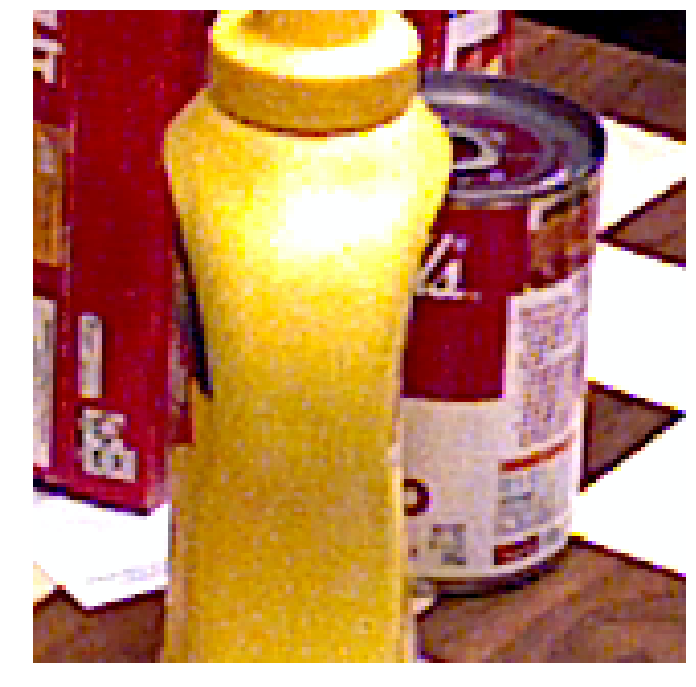

Uniform: 0.10132118364233776
hist_reg_global: 0.030540902091071707
hist_reg_idv_global: 0.005040587520698371
hist_comp_global: 0.09207528165878782
hist_conf: 4.848703729601167


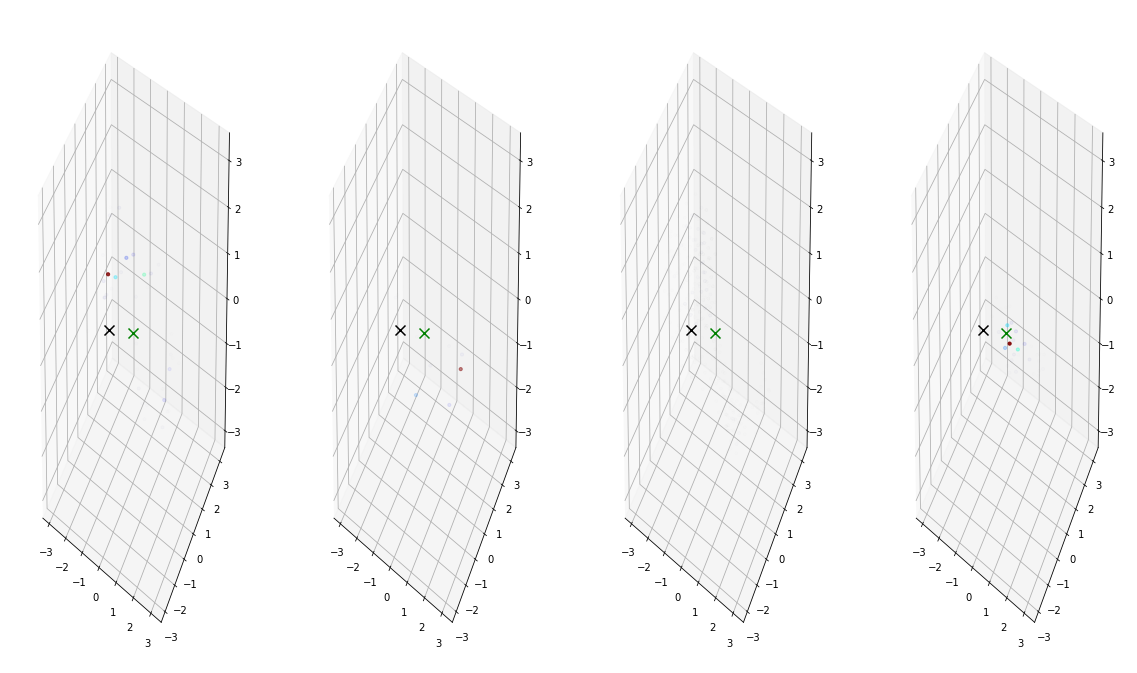

In [279]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = 20, 12

#idx = 12492 #np.random.randint(len(dataset))
idx = np.random.randint(len(dataset))
data = dataset[idx]
obj, quat, trans, img, points, choose = data
print(obj)
max_q, max_t, feat = evaluateDenseFusion(df_global_estimator, img, points, choose, obj)

imshowTorch(img, normalized=True)

knn_k = 200

max_pt = quats2Point([max_q])
gt_pt = quats2Point([to_np(quat)])

fig = plt.figure()
ax = fig.add_subplot(1,4,1, projection='3d')

print('Uniform: {}'.format(histLikelihood(np.ones(grid_size), quat, k = knn_k)))

#lik_est = evaluateFeature(reg_estimator, obj, feat, grid_features)
key = 'hist_reg_global'
lik_est, q_est, t_est = lik_funcs[key](img, points, choose, obj)
print('{}: {}'.format(key, histLikelihood(lik_est, quat, k = knn_k)))
#lik_est = lik_est > .001
scatterSO3New(to_np(grid_vertices), lik_est, ax=ax, clims = [0,.3], alims = [0,1], s=10)
ax.scatter(max_pt[:,0], max_pt[:,1], max_pt[:,2], c='k', s=100, marker='x')
ax.scatter(gt_pt[:,0], gt_pt[:,1], gt_pt[:,2], c='g',s=100, marker='x')

ax = fig.add_subplot(1,4,2, projection='3d')

key = 'hist_reg_idv_global'
lik_est, q_est, t_est = lik_funcs[key](img, points, choose, obj)
print('{}: {}'.format(key, histLikelihood(lik_est, quat, k = knn_k)))
#lik_est = lik_est > .001
scatterSO3New(to_np(grid_vertices), lik_est, ax=ax, clims = [0,.3], alims = [0,1], s=10)
ax.scatter(max_pt[:,0], max_pt[:,1], max_pt[:,2], c='k', s=100, marker='x')
ax.scatter(gt_pt[:,0], gt_pt[:,1], gt_pt[:,2], c='g', s=100, marker='x')

key = 'hist_comp_global'
ax = fig.add_subplot(1,4,3, projection='3d')
lik_est, q_est, t_est = lik_funcs[key](img, points, choose, obj)
print('{}: {}'.format(key, histLikelihood(lik_est, quat, k = knn_k)))
#lik_est = lik_est > .001
scatterSO3New(to_np(grid_vertices), lik_est, ax=ax, clims = [0,.3], alims = [0,1], s=10)
ax.scatter(max_pt[:,0], max_pt[:,1], max_pt[:,2], c='k', s=100, marker='x')
ax.scatter(gt_pt[:,0], gt_pt[:,1], gt_pt[:,2], c='g', s=100, marker='x')

key = 'hist_conf'
ax = fig.add_subplot(1,4,4, projection='3d')
lik_est, q_est, t_est = lik_funcs[key](img, points, choose, obj)
print('{}: {}'.format(key, histLikelihood(lik_est, quat, k = knn_k)))
#lik_est = lik_est > .001
scatterSO3New(to_np(grid_vertices), lik_est, ax=ax, clims = [0,.3], alims = [0,1], s=10)
ax.scatter(max_pt[:,0], max_pt[:,1], max_pt[:,2], c='k', s=100, marker='x')
ax.scatter(gt_pt[:,0], gt_pt[:,1], gt_pt[:,2], c='g', s=100, marker='x')
plt.show()

<IPython.core.display.Javascript object>


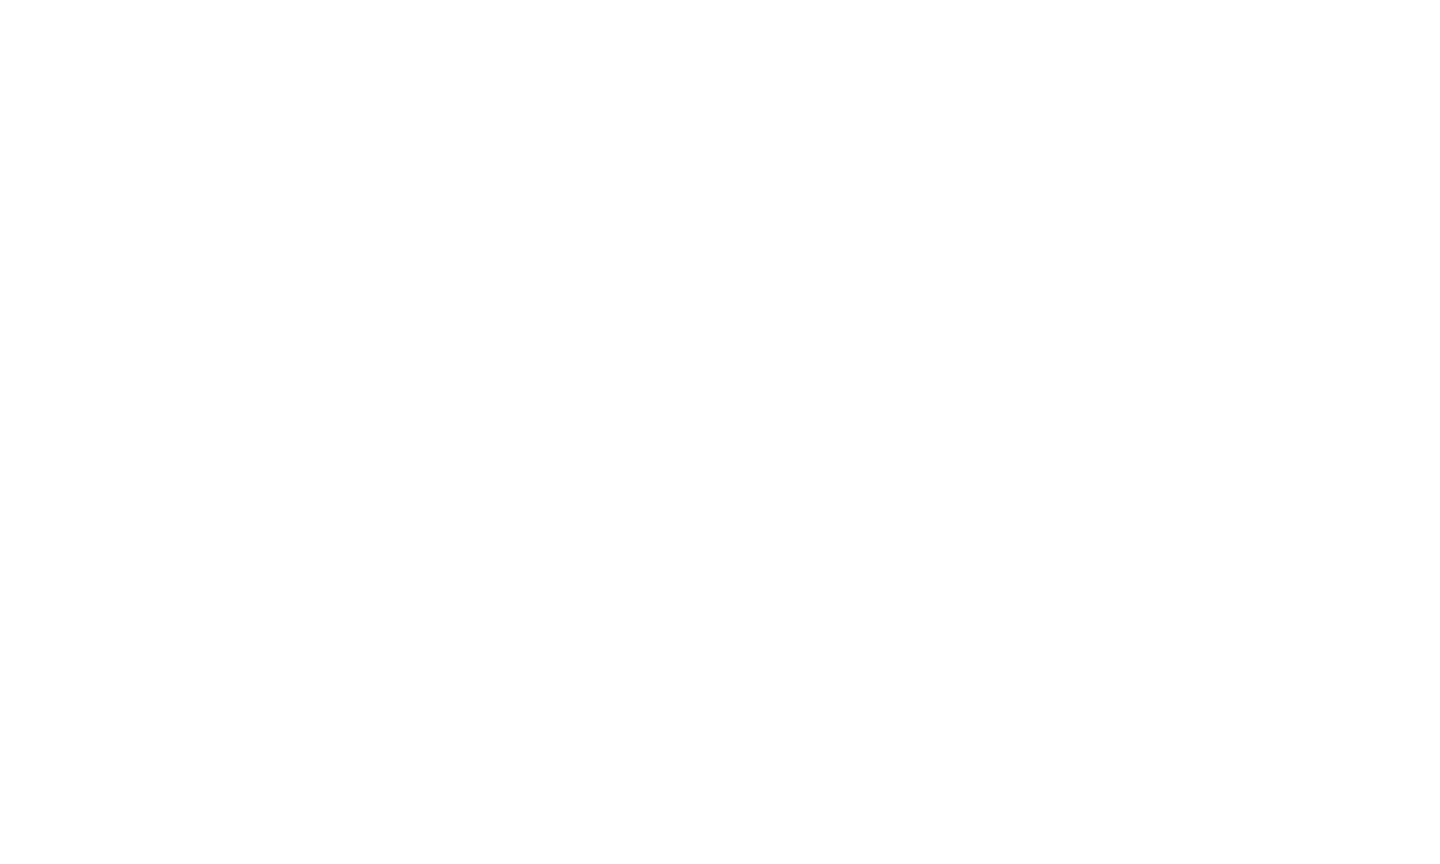

<IPython.core.display.Javascript object>


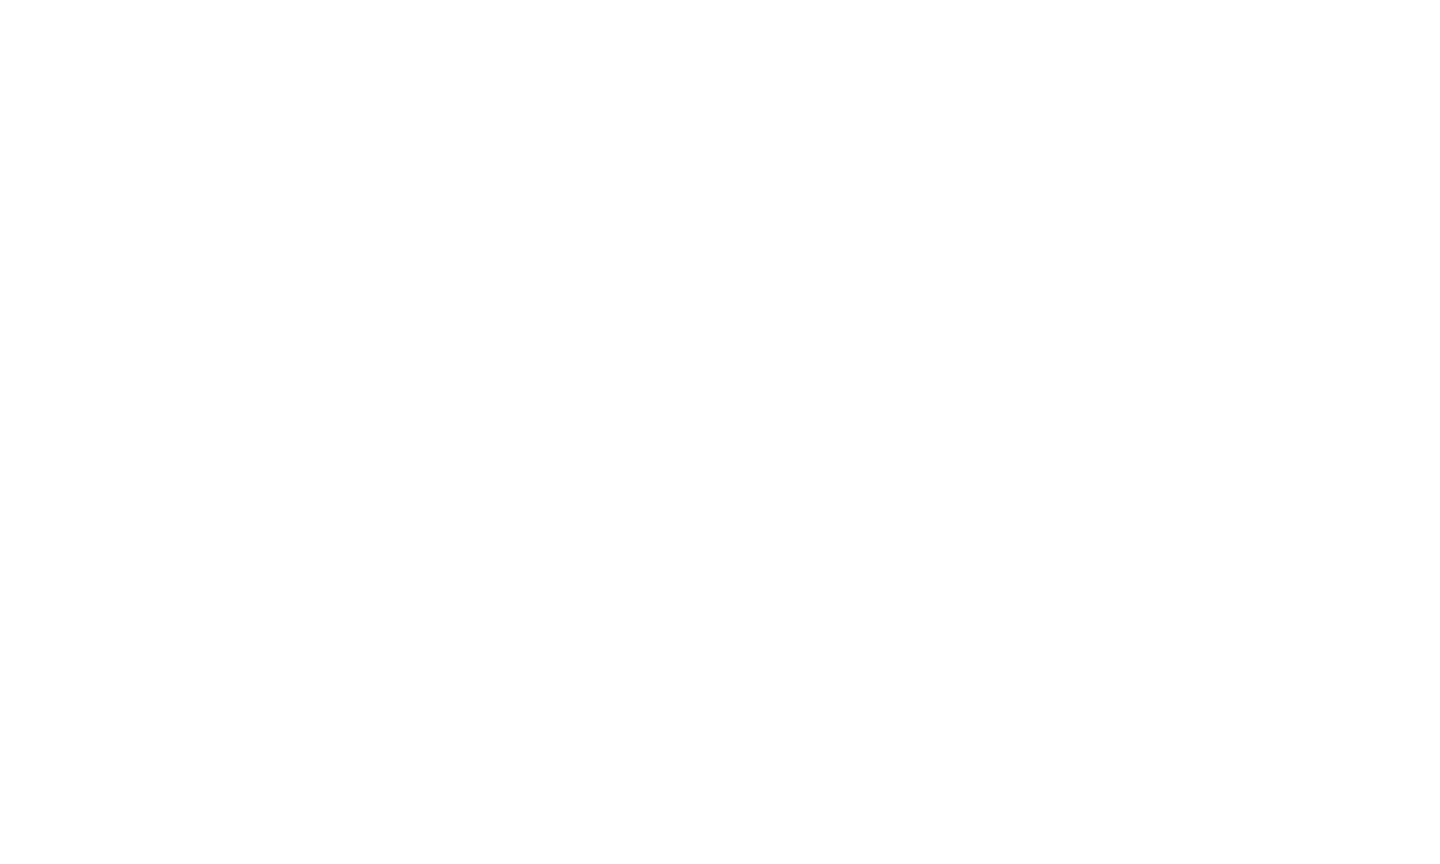

In [267]:
%matplotlib notebook 
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

lik_est, q_est, t_est = lik_funcs['hist_conf'](img, points, choose, obj)
#lik_est, q_est, t_est = lik_funcs['hist_reg_idv_global'](img, points, choose, obj)
scatterSO3New(to_np(grid_vertices), lik_est, [to_np(quat)], ax=ax, clims = [0,.3], alims = [0,1], s=1000)
gt_pt = quats2Point([to_np(quat)])
ax.scatter(gt_pt[:,0], gt_pt[:,1], gt_pt[:,2], c='b',s=100, marker='x')
#scatterSO3New(to_np(grid_vertices), dists < np.pi/2., [to_np(quat)], ax=ax, clims = [0,1], alims = [0,.01], s=10)
plt.show()


tensor([0.4427, 0.5862, 0.2771,  ..., 0.3220, 0.3494, 0.3422], device='cuda:0')